# This is implementation with pure Keras

## Has manual feature selection. 

### Has shuffling, normalisation, udf for model training, reproducibility

Validation data is passed as some pct of the training data, for early stopping rounds. And then finally predictions are made on unseen test data.

In [1]:
# Load Keras libraries used in this example

import keras
from keras import metrics
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam, RMSprop
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.utils import plot_model
from keras.models import load_model
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import random as rn
from keras import backend as K
import seaborn as sns
from sklearn.model_selection import train_test_split

# Loding data

In [4]:
all_data = pd.read_csv('data/train.csv')
all_data.shape

(1460, 81)

In [4]:
#separate the output column from the rest of your data
# prices=all_data['SalePrice']
# all_data.drop('SalePrice',axis=1,inplace=True)

In [5]:

# Dropping the id column
all_data.drop('Id',axis=1,inplace=True)

# all_data.drop('MSSubClass',axis=1,inplace=True)
all_data.shape

(1460, 80)

In [6]:
# #Feature selection should be done after data preprocessing.
# #Ideally  all the categorical variables should be encoded into numbers, so that we can assess how deterministic they are for target.
# #Currently we will be dealling with numerical columns only.
# colType = ['int64','float64']
# #Select the columns which are either int64 or float64.
# numCols=list(all_data.select_dtypes(include=colType).columns)
# #Assigning numerical columns from df to data variable. We can use the same variable as well.
# num_data=all_data[numCols]
# num_data.shape

In [6]:
all_data.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

# Handlig Missing values

In [7]:
all_data.isnull().sum().sort_values(ascending=False)

PoolQC           1453
MiscFeature      1406
Alley            1369
Fence            1179
FireplaceQu       690
LotFrontage       259
GarageType         81
GarageCond         81
GarageFinish       81
GarageQual         81
GarageYrBlt        81
BsmtFinType2       38
BsmtExposure       38
BsmtQual           37
BsmtCond           37
BsmtFinType1       37
MasVnrArea          8
MasVnrType          8
Electrical          1
RoofMatl            0
Exterior1st         0
RoofStyle           0
ExterQual           0
Exterior2nd         0
YearBuilt           0
ExterCond           0
Foundation          0
YearRemodAdd        0
SalePrice           0
OverallCond         0
                 ... 
GarageArea          0
PavedDrive          0
WoodDeckSF          0
OpenPorchSF         0
3SsnPorch           0
BsmtUnfSF           0
ScreenPorch         0
PoolArea            0
MiscVal             0
MoSold              0
YrSold              0
SaleType            0
Functional          0
TotRmsAbvGrd        0
KitchenQua

In [8]:
# Dropping the features with majority null values

# So, we will remove Alley, PoolQC, Fence and MiscFeature
all_data.drop('Alley', axis=1, inplace=True)
all_data.drop('PoolQC', axis=1, inplace=True)
all_data.drop('Fence', axis=1, inplace=True)
all_data.drop('MiscFeature', axis=1, inplace=True)

In [9]:
#FireplaceQu
all_data['FireplaceQu'] = all_data['FireplaceQu'].fillna('NF') # No fireplace

#LotFrontage
# all_data['LotFrontage'].mode() ---> 60
all_data['LotFrontage'] = all_data['LotFrontage'].fillna(60)

# Basement columns
for col in ['BsmtFinType2','BsmtExposure','BsmtQual','BsmtFinType1','BsmtCond']:
    all_data[col] = all_data[col].fillna('NB') # No basement

# Garage columns
for col in ['GarageType','GarageYrBlt','GarageFinish','GarageQual','GarageCond']:
    all_data[col] = all_data[col].fillna('NG') # No garage
    
# Dropping nans for the following cols
for col in ['MasVnrType','MasVnrArea','Electrical']:
    all_data.dropna(inplace=True)

In [10]:
all_data.isnull().sum().sort_values(ascending=False)

SalePrice        0
Foundation       0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
BsmtQual         0
SaleCondition    0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinSF1       0
BsmtFinType2     0
BsmtFinSF2       0
BsmtUnfSF        0
RoofStyle        0
YearRemodAdd     0
YearBuilt        0
OverallCond      0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
                ..
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea         0
MiscVal          0
MoSold           0
YrSold           0
SaleType         0
GarageFinish     0
GarageType       0
CentralAir       0
FireplaceQu      0
Electrical       0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath    

# Manually Selecting Features

In [11]:
all_data.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF'

In [12]:
def correlation(dataset,threshold):
    col_corr=set() # set will contains unique values.
    corr_matrix=dataset.corr() #finding the correlation between columns.
    for i in range(len(corr_matrix.columns)): #number of columns
        for j in range(i):
#             print(corr_matrix.columns[i],corr_matrix.columns[j],corr_matrix.iloc[i,j])
            if abs(corr_matrix.iloc[i,j])>=threshold: #checking the correlation between columns.
                colName=corr_matrix.columns[i] #getting the column name
                col_corr.add(colName) #adding the correlated column name heigher than threshold value.
    return col_corr #returning set of column names
col=correlation(all_data.loc[:,all_data.columns!='SalePrice'],0.8)
print('Correlated columns:',col) 
col = list(col)

Correlated columns: {'TotRmsAbvGrd', 'GarageArea', '1stFlrSF'}


So, we will remove the above co-related features.

In [14]:
all_data = all_data.drop(columns=col,axis=1)

In [15]:
all_data.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'KitchenQual', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPor

In [16]:
all_data.shape

(1451, 73)

# Handling Categorical Columns

In [17]:
all_data1 = pd.get_dummies(all_data)

# Train Test Split

In [18]:
def split_train_test(df,label_col,test_size=0.2):
    
    X = df.loc[:,df.columns != label_col]
    y = df[label_col]

    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=test_size, random_state=42)
    
    return train_x, test_x, train_y, test_y

In [19]:
train_x, test_x, train_y, test_y = split_train_test(all_data1,label_col='SalePrice')

In [20]:
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((1160, 379), (291, 379), (1160,), (291,))

# Create the model

Let's build our model. Here, we'll use a Sequential model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, build_model, since we'll create a second model, later on.

In [21]:
def build_model(train_x):
    
#     model = Sequential()
#     print('No of input features',train_x.shape[1])
#     model.add(Dense(128,activation="relu",input_shape=(train_x.shape[1],)))
#     model.add(Dense(64,activation="relu"))
#     model.add(Dense(1))
    
#     model.compile(loss='mean_squared_error',
#                     optimizer=RMSprop(lr=0.001),
#                     metrics=[metrics.mae])
#     print(model.summary())

    model = Sequential()
    BatchNormalization()
    model.add(Dense(1028,input_dim=train_x.shape[1],activation='relu'))
#     BatchNormalization()
#     model.add(Dense(1028,input_dim=train_x.shape[1],activation='relu'))
#     BatchNormalization()
    #Dropout(0.2)
    model.add(Dense(100,activation='relu'))
    BatchNormalization()
    #Dropout(0.2)
    model.add(Dense(50))
    BatchNormalization()
    model.add(Dense(1))
    model.compile(optimizer='adam',loss='mse',metrics=[metrics.mae])
    return model

# Train the model

In [29]:
def model_train(model, train_x, train_y, epochs=500, batch_size=100,valid_pct=0.2, early_stopping_rounds = 20,verbose=0):
    
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stopping_rounds)
    
    history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size,
                    validation_split=valid_pct, verbose=verbose,
                    callbacks=[early_stop])
    
    valid_data_x = train_x.tail(int(valid_pct*train_x.shape[0]))
    valid_data_y = train_y.tail(int(valid_pct*train_y.shape[0]))
    
    [valid_mse, valid_mae] = model.evaluate(valid_data_x,valid_data_y,verbose=0)
    print("Valid set Mean Abs Error: {:7.2f}".format(valid_mae))
    print("Valid set Root Mean Sqd Error : {:7.2f}".format((valid_mse ** 0.5)))
    valid_error = (valid_mse ** 0.5) / valid_data_y.mean()
    print('Percentage error on Valid Set:',valid_error*100,'%')
    
    [loss, mae] = model.evaluate(test_x, test_y, verbose=0)

    print("Testing set Mean Abs Error: {:7.2f}".format(mae))
    print("Testing set Root Mean Sqd Error : {:7.2f}".format((loss ** 0.5)))
    
    return loss,mae

In [23]:
import os
os.environ['PYTHONHASHSEED'] = '0'

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(12345)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of
# non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(1234)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

model = build_model(train_x)

loss,mae = model_train(model=model, train_x=train_x, train_y=train_y, epochs=500, batch_size=128, valid_pct=0.2, early_stopping_rounds = 50, verbose=2)

Train on 928 samples, validate on 232 samples
Epoch 1/500
 - 0s - loss: 37300920531.8621 - mean_absolute_error: 175892.7613 - val_loss: 33332203731.8621 - val_mean_absolute_error: 165640.6347
Epoch 2/500
 - 0s - loss: 29366343115.0345 - mean_absolute_error: 152678.7387 - val_loss: 21145472529.6552 - val_mean_absolute_error: 126410.5003
Epoch 3/500
 - 0s - loss: 17297876780.1379 - mean_absolute_error: 103892.8068 - val_loss: 7028326982.6207 - val_mean_absolute_error: 59763.4081
Epoch 4/500
 - 0s - loss: 13144274136.2759 - mean_absolute_error: 58576.6837 - val_loss: 4556395105.1034 - val_mean_absolute_error: 47475.5521
Epoch 5/500
 - 0s - loss: 11313647262.8966 - mean_absolute_error: 52354.2416 - val_loss: 4430578334.8966 - val_mean_absolute_error: 45808.0559
Epoch 6/500
 - 0s - loss: 7814778632.8276 - mean_absolute_error: 48895.9793 - val_loss: 4179476179.8621 - val_mean_absolute_error: 44462.8067
Epoch 7/500
 - 0s - loss: 6418728024.2759 - mean_absolute_error: 46441.0280 - val_loss: 36

Epoch 58/500
 - 0s - loss: 2293517515.0345 - mean_absolute_error: 29441.7080 - val_loss: 1639558263.1724 - val_mean_absolute_error: 29159.7726
Epoch 59/500
 - 0s - loss: 2293951408.5517 - mean_absolute_error: 29255.9157 - val_loss: 1620467950.3448 - val_mean_absolute_error: 29032.5234
Epoch 60/500
 - 0s - loss: 2283984578.2069 - mean_absolute_error: 29008.7317 - val_loss: 1631405069.2414 - val_mean_absolute_error: 29055.7223
Epoch 61/500
 - 0s - loss: 2259263713.1034 - mean_absolute_error: 29045.2049 - val_loss: 1613677347.3103 - val_mean_absolute_error: 28966.0438
Epoch 62/500
 - 0s - loss: 2239877261.2414 - mean_absolute_error: 28995.3370 - val_loss: 1618584183.1724 - val_mean_absolute_error: 28921.3869
Epoch 63/500
 - 0s - loss: 2230194138.4828 - mean_absolute_error: 28901.5117 - val_loss: 1606561619.8621 - val_mean_absolute_error: 28856.5348
Epoch 64/500
 - 0s - loss: 2225616843.0345 - mean_absolute_error: 28862.7058 - val_loss: 1614416768.0000 - val_mean_absolute_error: 28874.0140

Epoch 116/500
 - 0s - loss: 1689067060.9655 - mean_absolute_error: 26913.5084 - val_loss: 1571540449.1034 - val_mean_absolute_error: 27391.4925
Epoch 117/500
 - 0s - loss: 1678527108.4138 - mean_absolute_error: 26577.5147 - val_loss: 1536233454.3448 - val_mean_absolute_error: 27166.8786
Epoch 118/500
 - 0s - loss: 1651572020.9655 - mean_absolute_error: 26440.7159 - val_loss: 1531241317.5172 - val_mean_absolute_error: 26981.7006
Epoch 119/500
 - 0s - loss: 1668198539.0345 - mean_absolute_error: 26760.0981 - val_loss: 1552503534.3448 - val_mean_absolute_error: 27134.2142
Epoch 120/500
 - 0s - loss: 1674754348.1379 - mean_absolute_error: 26929.7524 - val_loss: 1544758563.3103 - val_mean_absolute_error: 27315.5987
Epoch 121/500
 - 0s - loss: 1674117345.1034 - mean_absolute_error: 26642.9059 - val_loss: 1570792584.8276 - val_mean_absolute_error: 27163.0300
Epoch 122/500
 - 0s - loss: 1665531837.7931 - mean_absolute_error: 26354.1615 - val_loss: 1601594398.8966 - val_mean_absolute_error: 273

Epoch 173/500
 - 0s - loss: 1296117071.4483 - mean_absolute_error: 24212.0490 - val_loss: 1616128260.4138 - val_mean_absolute_error: 26054.2367
Epoch 174/500
 - 0s - loss: 1357321785.3793 - mean_absolute_error: 25512.1784 - val_loss: 1541617873.6552 - val_mean_absolute_error: 25916.7724
Epoch 175/500
 - 0s - loss: 1281541684.9655 - mean_absolute_error: 24447.7313 - val_loss: 1590377233.6552 - val_mean_absolute_error: 26318.2821
Epoch 176/500
 - 0s - loss: 1263920092.6897 - mean_absolute_error: 24447.8537 - val_loss: 1521829601.1034 - val_mean_absolute_error: 24989.8092
Epoch 177/500
 - 0s - loss: 1229376684.1379 - mean_absolute_error: 23959.0917 - val_loss: 1707282935.1724 - val_mean_absolute_error: 27181.9591
Epoch 178/500
 - 0s - loss: 1291470212.4138 - mean_absolute_error: 24660.7693 - val_loss: 1506039655.7241 - val_mean_absolute_error: 25212.6755
Epoch 179/500
 - 0s - loss: 1184981817.3793 - mean_absolute_error: 23204.2935 - val_loss: 1499355709.7931 - val_mean_absolute_error: 248

 - 0s - loss: 777534752.0000 - mean_absolute_error: 18939.4264 - val_loss: 1229699385.3793 - val_mean_absolute_error: 21962.6204
Epoch 231/500
 - 0s - loss: 811625032.8276 - mean_absolute_error: 19284.5226 - val_loss: 1220221627.5862 - val_mean_absolute_error: 21332.2082
Epoch 232/500
 - 0s - loss: 754484608.0000 - mean_absolute_error: 18804.5102 - val_loss: 1211519095.1724 - val_mean_absolute_error: 21106.2872
Epoch 233/500
 - 0s - loss: 779178277.5172 - mean_absolute_error: 19450.9287 - val_loss: 1352943805.7931 - val_mean_absolute_error: 22865.8834
Epoch 234/500
 - 0s - loss: 800198898.7586 - mean_absolute_error: 19486.5589 - val_loss: 1224535916.1379 - val_mean_absolute_error: 21352.1167
Epoch 235/500
 - 0s - loss: 783482835.8621 - mean_absolute_error: 18863.1363 - val_loss: 1198523791.4483 - val_mean_absolute_error: 21125.3256
Epoch 236/500
 - 0s - loss: 766695609.3793 - mean_absolute_error: 18758.1582 - val_loss: 1182378156.1379 - val_mean_absolute_error: 20828.7076
Epoch 237/500

Epoch 288/500
 - 0s - loss: 537304585.9310 - mean_absolute_error: 16257.8716 - val_loss: 1086258679.1724 - val_mean_absolute_error: 20624.6763
Epoch 289/500
 - 0s - loss: 573945751.1724 - mean_absolute_error: 17129.6812 - val_loss: 1297704646.6207 - val_mean_absolute_error: 24546.5647
Epoch 290/500
 - 0s - loss: 684171683.3103 - mean_absolute_error: 18892.4925 - val_loss: 1096664161.1034 - val_mean_absolute_error: 20527.0041
Epoch 291/500
 - 0s - loss: 579909526.0690 - mean_absolute_error: 16805.9240 - val_loss: 1035729602.2069 - val_mean_absolute_error: 19618.5983
Epoch 292/500
 - 0s - loss: 535371080.8276 - mean_absolute_error: 16146.8644 - val_loss: 1039874030.3448 - val_mean_absolute_error: 19566.9746
Epoch 293/500
 - 0s - loss: 519978070.0690 - mean_absolute_error: 15802.2670 - val_loss: 1048788131.3103 - val_mean_absolute_error: 19629.9716
Epoch 294/500
 - 0s - loss: 556353891.3103 - mean_absolute_error: 16483.8450 - val_loss: 1116012872.8276 - val_mean_absolute_error: 20941.6936

Epoch 346/500
 - 0s - loss: 447614388.9655 - mean_absolute_error: 14658.2672 - val_loss: 960838585.3793 - val_mean_absolute_error: 18897.4415
Epoch 347/500
 - 0s - loss: 449211632.0000 - mean_absolute_error: 15051.7724 - val_loss: 1092485128.8276 - val_mean_absolute_error: 20805.3629
Epoch 348/500
 - 0s - loss: 449457844.9655 - mean_absolute_error: 15408.4752 - val_loss: 1026472289.1034 - val_mean_absolute_error: 20011.0223
Epoch 349/500
 - 0s - loss: 454265613.2414 - mean_absolute_error: 14978.1478 - val_loss: 958166040.2759 - val_mean_absolute_error: 18780.7757
Epoch 350/500
 - 0s - loss: 433826160.5517 - mean_absolute_error: 14709.2558 - val_loss: 1063613614.3448 - val_mean_absolute_error: 20761.7590
Epoch 351/500
 - 0s - loss: 508808721.6552 - mean_absolute_error: 16300.2770 - val_loss: 990309929.9310 - val_mean_absolute_error: 19813.6220
Epoch 352/500
 - 0s - loss: 477956301.2414 - mean_absolute_error: 15685.0643 - val_loss: 985257213.7931 - val_mean_absolute_error: 19135.2015
Epo

Epoch 404/500
 - 0s - loss: 412687401.9310 - mean_absolute_error: 14527.5828 - val_loss: 991857712.5517 - val_mean_absolute_error: 19452.6040
Epoch 405/500
 - 0s - loss: 438067943.7241 - mean_absolute_error: 15236.1174 - val_loss: 1156227590.6207 - val_mean_absolute_error: 22712.4605
Epoch 406/500
 - 0s - loss: 477543181.2414 - mean_absolute_error: 15937.1251 - val_loss: 934200280.2759 - val_mean_absolute_error: 18414.1929
Epoch 407/500
 - 0s - loss: 459437885.7931 - mean_absolute_error: 15782.6444 - val_loss: 1078953352.8276 - val_mean_absolute_error: 20712.4274
Epoch 408/500
 - 0s - loss: 415645830.6207 - mean_absolute_error: 14779.3900 - val_loss: 978928414.8966 - val_mean_absolute_error: 19450.5122
Epoch 409/500
 - 0s - loss: 400067956.9655 - mean_absolute_error: 14205.2068 - val_loss: 987049196.1379 - val_mean_absolute_error: 19138.7912
Epoch 410/500
 - 0s - loss: 391102223.4483 - mean_absolute_error: 14034.6269 - val_loss: 941432258.2069 - val_mean_absolute_error: 18501.9543
Epoc

Epoch 462/500
 - 0s - loss: 316107190.0690 - mean_absolute_error: 12556.0508 - val_loss: 951073026.2069 - val_mean_absolute_error: 18330.9478
Epoch 463/500
 - 0s - loss: 315205590.0690 - mean_absolute_error: 12504.8151 - val_loss: 942150819.3103 - val_mean_absolute_error: 18327.8336
Epoch 464/500
 - 0s - loss: 311951630.3448 - mean_absolute_error: 12504.5661 - val_loss: 958176333.2414 - val_mean_absolute_error: 18394.8237
Epoch 465/500
 - 0s - loss: 313882245.5172 - mean_absolute_error: 12504.3682 - val_loss: 945898789.5172 - val_mean_absolute_error: 18236.9102
Epoch 466/500
 - 0s - loss: 319288070.6207 - mean_absolute_error: 12642.8178 - val_loss: 953060566.0690 - val_mean_absolute_error: 18847.1478
Epoch 467/500
 - 0s - loss: 322851130.4828 - mean_absolute_error: 12739.3941 - val_loss: 939847384.2759 - val_mean_absolute_error: 18283.4636
Epoch 468/500
 - 0s - loss: 380460576.0000 - mean_absolute_error: 14349.7365 - val_loss: 1022639563.0345 - val_mean_absolute_error: 19692.5303
Epoch

# Predicting on the Test data

In [24]:
test_predictions = model.predict(test_x).flatten()

In [25]:
predictions = pd.DataFrame(index=range(len(test_y)))
predictions['actual'] = pd.DataFrame(test_y.reset_index(drop=True))
predictions['preds'] = pd.DataFrame(test_predictions)

In [26]:
predictions

,actual,preds
0,315000,330745.000000
1,158900,147011.671875
2,127000,125946.421875
3,210000,201283.328125
4,260000,253204.234375
5,183200,195813.156250
6,185850,226582.859375
7,143500,130702.875000
8,165000,158994.437500
9,100000,124814.429688


In [27]:
# Mean and std of actual values in the test data.
predictions.actual.mean(), predictions.actual.std()

(179989.3883161512, 74821.7736464718)

In [28]:
# Percent error wrt to the mean actual price
print('Percent error: ',(loss ** 0.5)/predictions.actual.mean()*100,'%')

Percent error:  16.727231522938695 %


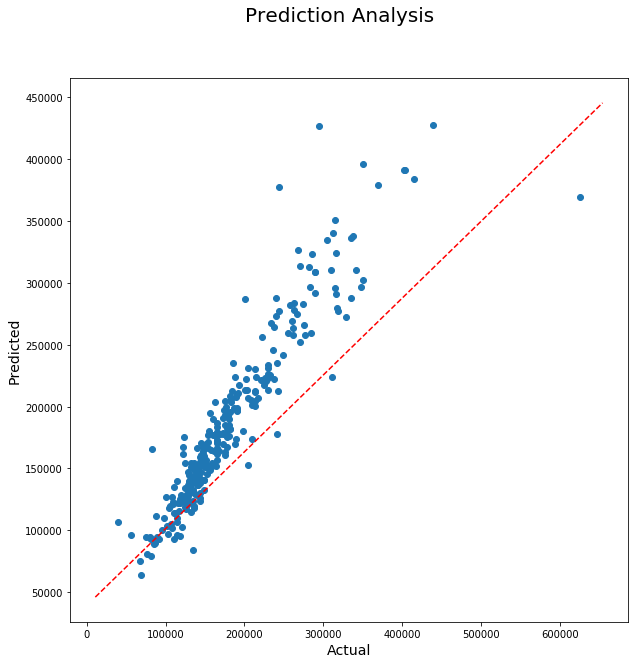

In [65]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(predictions.actual,predictions.preds)
fig.suptitle('Prediction Analysis', fontsize=20)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c="r")
plt.xlabel('Actual', fontsize=14)
plt.ylabel('Predicted', fontsize=14)
plt.show()

# Conclusion

The results are worse than the case when all features are not passed to the model